# Data Modeling:

## Regression model with target feature price 

Now that we have a clean dataframe with no multicollinearity, we can attempt to create models. 

## Summary:
* All models use price_log as target variable.
* Model 1 includes all features.
* Model 2 includes all features with categorical outliers removed. 
* Model 3 includes the top 4 features that correlate highest with price_log. Simple model attempt. 

**Main Goals for model fitting:**
* Fit an intial regression model. Using statistical analysis look at the p-value of features and determine which features are important and which are not statistically significant.
* Test for normality. 
* Test for heteroscedasticity.  
* From the tests we can evaluate the performance of our models.

In [114]:
#import all neccesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

There are 3 main assumptions for regression models: 

**Linearity:** 
* There needs to be a linear relationship between the target variable and the predictors being used. 

**Normality:** 
* The residual erros from the model are to be assumed as normally distributed. This can be checked using a Qunatile-Quantile Plot. 

**Homoscedasticity:** 
* The residual erros from the model should not be correlated with the target variable or any predictors. This can be viewed through a residual plot. The erros must bve random. 

In [115]:
# read cleaned dataframe
clean = pd.read_csv('../data/clean.csv', index_col=0)
clean.head()

,price_log,sqft_lot_log,sqft_above_log,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,...,zipcode_90.0,zipcode_91.0,zipcode_92.0,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0
21177,12.422989,10.591823,7.489971,3,1.5,1.0,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
10844,13.319574,9.462343,7.710653,4,1.5,1.5,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
9292,13.835313,9.626152,7.229839,5,2.0,1.0,4,8,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,13.321214,9.651945,7.098376,5,2.0,1.0,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
14450,13.458836,9.061840,7.450080,3,2.0,1.5,5,7,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model 1 with with all features included and target variable price_log

In [116]:
# Specify the model parameters
X = clean.drop(labels='price_log', axis=1)
y = clean['price_log']

# Create model
model1 = sm.OLS(y, sm.add_constant(X))
model1_results = model1.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     197.4
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:41:36   Log-Likelihood:                -8322.2
No. Observations:               30110   AIC:                         1.735e+04
Df Residuals:                   29758   BIC:                         2.027e+04
Df Model:                         351                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

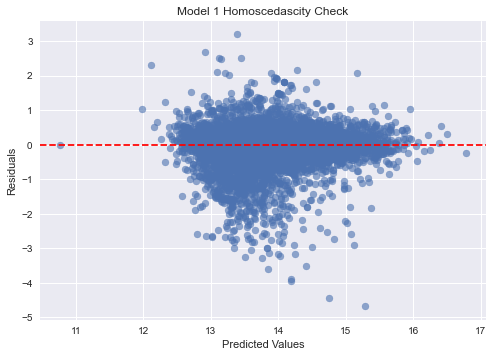

In [117]:
# View model predictions
predicted_values = model1_results.fittedvalues
residuals = model1_results.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.6)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 1 Homoscedascity Check')
plt.grid(True)
plt.show()

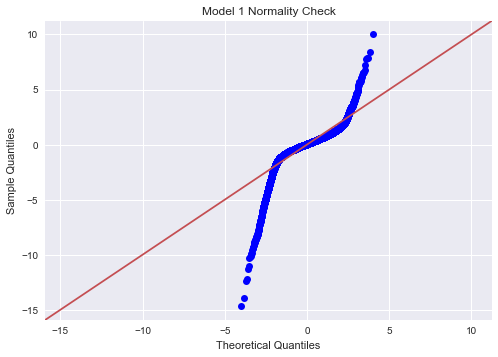

In [118]:
sm.graphics.qqplot(model1_results.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 1 Normality Check")
plt.show()

In [119]:
# Get the predictions from the fitted model
predictions = model1_results.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.3190063507196301
Model Predictions are off by a factor of 1.38 times the actual price.


**Observations:**
* Overall the model is statistically significant with the F-statistic p-value less than 0.05.
* The model explains about 70% percent of the variance in price_log
* There are non statistically significant features that include some of the zipcodes, bedrooms, garage 1.0, heat_Gas/Oil
* The model dooes not seem to have a normal distribution despite log transformation and standardizing the continous data in the data_preparation process. 
* The model does well in only a certain range of values which probably explains the MSE value which is close to zero. 
* There are outliers as we can see in the residual plot. 
* The residuals however show Heteroscedascity which is not good. It should be have a behavior known as Homoscedascity where the data is randmonly scattered.
* The models predictions according to the RMSE are off by a factor of 1.38 times the actual price prediction. 

Eliminate any features above 0.05 p-value as these features are considered not significant for the model. 

In [120]:
import pandas as pd
import statsmodels.api as sm

# Specify the model parameters
X = clean.drop(labels='price_log', axis=1)
y = clean['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [121]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     622.7
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:41:38   Log-Likelihood:                -8433.0
No. Observations:               30110   AIC:                         1.709e+04
Df Residuals:                   29998   BIC:                         1.802e+04
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

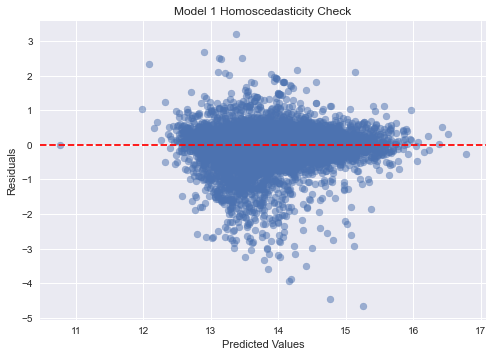

In [122]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 1 Homoscedasticity Check')
plt.grid(True)
plt.show()

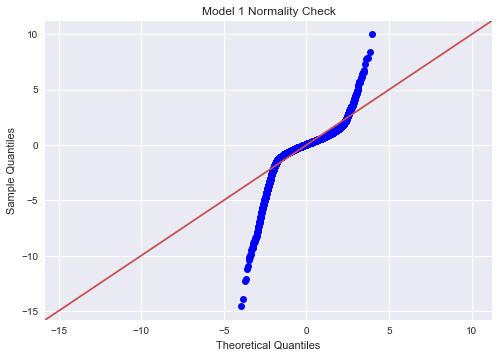

In [123]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 1 Normality Check")
plt.show()

In [124]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.32018251682706217
Model Predictions are off by a factor of 1.38 times the actual price.


Visualize coefficients

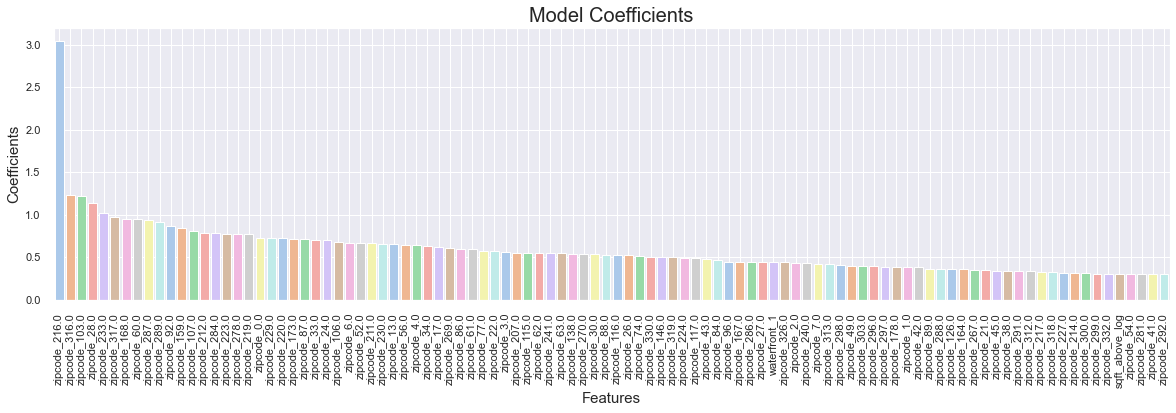

In [125]:
# Get the coefficients from the fitted model
coefficients = model1_results.params

# Determine top 30 features 
top_features = coefficients.drop('const').abs().nlargest(100)

# Create a bar graph to visualize the coefficients
# Set custom font sizes for the plot
sns.set(font_scale=1.0)
plt.figure(figsize=(20, 5))
sns.barplot(x=top_features.index, y=top_features.values, palette='pastel')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Coefficients', fontsize=15)
plt.title('Model Coefficients', fontsize=20)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.grid(True)  
plt.show()

**Observations:**
* Overall the model is statistically significant with the F-statistic p-value less than 0.05.
* The model explains about 70% percent of the variance in price_log.
* The model dooes not seem to have a normal distribution despite log transformation and standardizing the continous data in the data_preparation process. 
* The model does well in only a certain range of values which probably explains the MSE value which is close to zero. 
* There are outliers as we can see in the residual plot. The kurtosis value also suggets outliers as well. 
* The residuals however show Heteroscedascity which is not good. It should be have a behavior known as Homoscedascity where the data is randmonly scattered.


## Model 1a with removed outliers on all features representing 95% of the data. 

In [126]:
for col in clean.columns:
    print(col)

price_log
sqft_lot_log
sqft_above_log
bedrooms
bathrooms
floors
condition_num
extracted_grade_num
waterfront_1
greenbelt_1
basement_1.0
garage_1.0
patio_1.0
sewer_PUBLIC
heat_Electricity/Solar
heat_Gas
heat_Gas/Solar
heat_Oil
zipcode_0.0
zipcode_1.0
zipcode_10.0
zipcode_100.0
zipcode_101.0
zipcode_102.0
zipcode_103.0
zipcode_104.0
zipcode_105.0
zipcode_106.0
zipcode_107.0
zipcode_108.0
zipcode_109.0
zipcode_11.0
zipcode_110.0
zipcode_111.0
zipcode_112.0
zipcode_113.0
zipcode_114.0
zipcode_115.0
zipcode_116.0
zipcode_117.0
zipcode_118.0
zipcode_119.0
zipcode_12.0
zipcode_120.0
zipcode_121.0
zipcode_122.0
zipcode_123.0
zipcode_124.0
zipcode_125.0
zipcode_126.0
zipcode_127.0
zipcode_128.0
zipcode_129.0
zipcode_13.0
zipcode_130.0
zipcode_131.0
zipcode_132.0
zipcode_133.0
zipcode_134.0
zipcode_135.0
zipcode_136.0
zipcode_137.0
zipcode_138.0
zipcode_139.0
zipcode_14.0
zipcode_140.0
zipcode_141.0
zipcode_142.0
zipcode_143.0
zipcode_144.0
zipcode_145.0
zipcode_146.0
zipcode_147.0
zipcode_148.0

Before removeing outlier we have to convert log transformation back to original to better scope the outliers 

In [127]:
# Create copy of df
model1_out = clean.copy()
# Covert values back to original values
model1_out['price'] = np.exp(model1_out['price_log'])
model1_out['sqft_above'] = np.exp(model1_out['sqft_above_log'])
model1_out['sqft_lot'] = np.exp(model1_out['sqft_lot_log'])
# Drop old values
model1_out.drop(labels=['price_log', 'sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

Drop outliers 

In [128]:
import numpy as np

# Create subset of columns
columns_of_interest = ['price', 'sqft_above', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition_num', 'extracted_grade_num']

# Define a function to remove outliers from a specific column 2 std away from mean
def remove_outliers(df, column_name, cutoff):
    mean = np.mean(df[column_name])
    std = np.std(df[column_name])
    cut_off = std * cutoff
    
    # Find outliers
    outliers = df[abs(df[column_name] - mean) >= cut_off]
    # Count the number of outliers removed
    num_outlier_removed = len(outliers)
    # Drop outlier from dataframe
    df.drop(outliers.index, inplace=True)
    
    return df, num_outlier_removed 

# Create a dictionary so we can inspect how many outliers were removed per column
outliers_removed_count = {}

# Loop through the columns of interest and remove outliers
for col in columns_of_interest:
    model1_out, num_outliers_removed = remove_outliers(model1_out, col, 2)
    outliers_removed_count[col] = num_outliers_removed

print(outliers_removed_count)

model1_out.head()

{'price': 945, 'sqft_above': 1331, 'sqft_lot': 443, 'bedrooms': 810, 'bathrooms': 469, 'floors': 1117, 'condition_num': 3190, 'extracted_grade_num': 730}


,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,patio_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_above,sqft_lot
21177,3,1.5,1.0,4,7,0,0,0,1,1,...,0,0,0,0,0,0,0,248448.0,1790.0,39808.0
10844,4,1.5,1.5,4,7,0,0,0,1,1,...,0,0,0,0,0,0,0,609000.0,2232.0,12866.0
9292,5,2.0,1.0,4,8,0,0,1,0,0,...,0,0,0,0,0,0,0,1020000.0,1380.0,15156.0
17878,5,2.0,1.0,3,7,0,0,1,0,1,...,0,0,0,0,0,0,0,610000.0,1210.0,15552.0
11853,3,1.0,1.5,4,6,0,0,1,0,1,...,0,0,0,0,0,0,0,460000.0,1010.0,7599.0


Convert them back to log 

In [129]:
# Covert values back to original values
model1_out['price_log'] = np.log(model1_out['price'])
model1_out['sqft_above_log'] = np.log(model1_out['sqft_above'])
model1_out['sqft_lot_log'] = np.log(model1_out['sqft_lot'])
# Drop old values
model1_out.drop(labels=['price', 'sqft_above', 'sqft_lot'], axis=1, inplace=True)

In [130]:
import pandas as pd
import statsmodels.api as sm

# Specify the model parameters
X = model1_out.drop(labels='price_log', axis=1)
y = model1_out['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [131]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     325.4
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:41:44   Log-Likelihood:                -4557.7
No. Observations:               21075   AIC:                             9321.
Df Residuals:                   20972   BIC:                         1.014e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.2853    

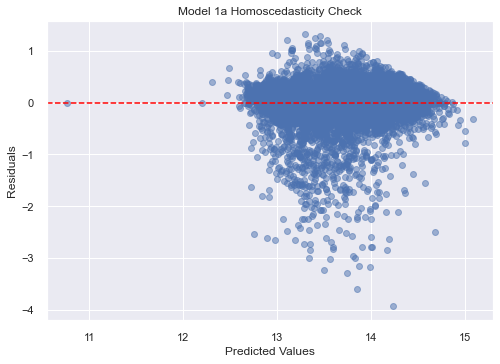

In [132]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 1a Homoscedasticity Check')
plt.grid(True)
plt.show()

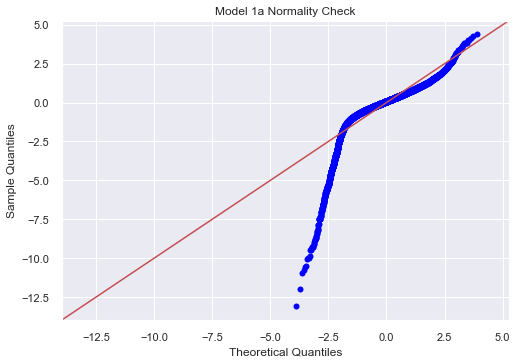

In [133]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 1a Normality Check")
plt.show()

In [134]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.30038837634144505
Model Predictions are off by a factor of 1.35 times the actual price.


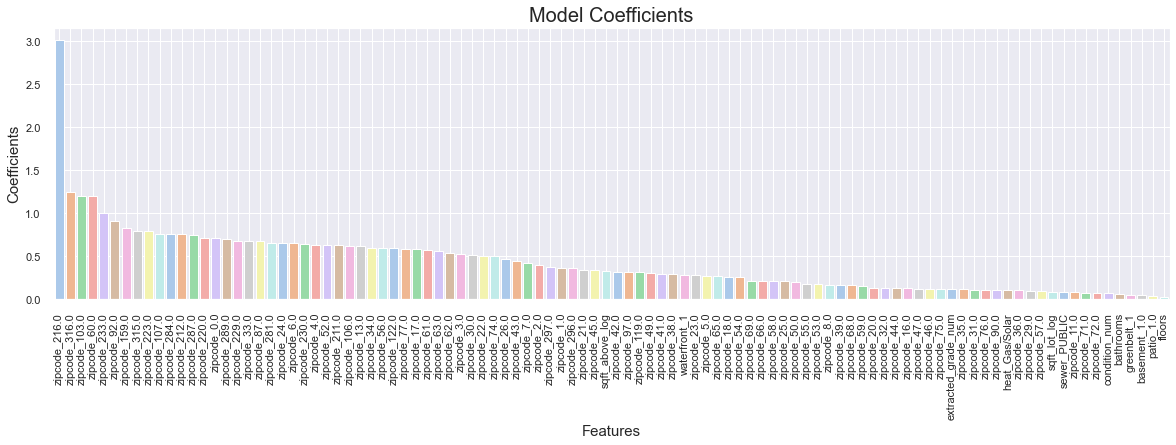

In [135]:
# Get the coefficients from the fitted model
coefficients = model.params

# Determine top 30 features 
top_features = coefficients.drop('const').abs().nlargest(100)

# Create a bar graph to visualize the coefficients
# Set custom font sizes for the plot
sns.set(font_scale=1.0)
plt.figure(figsize=(20, 5))
sns.barplot(x=top_features.index, y=top_features.values, palette='pastel')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Coefficients', fontsize=15)
plt.title('Model Coefficients', fontsize=20)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.grid(True)  
plt.show()

**Observations:**
* We have a Homoscedasticity Fail. 
* We fail the normality check as we still have heavy outliers on one tail despite log transformation on all continuous features and removal of outliers 2 std away. 
* This model represents 60% of the variance found in price_log. 
* The Model Predictions are off by a factor of 1.35 times the actual price.

**Next Steps:**
* Make a model with 68% percent representation/1 std away. 

## Model 1b with Outliers removed and 68% data representation. 

In [136]:
# Create copy of df
model1b_out = clean.copy()

In [137]:
# Convert values back to original values
model1b_out['price'] = np.exp(model1b_out['price_log'])
model1b_out['sqft_above'] = np.exp(model1b_out['sqft_above_log'])
model1b_out['sqft_lot'] = np.exp(model1b_out['sqft_lot_log'])
# Drop old values
model1b_out.drop(labels=['price_log', 'sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

In [138]:
# Create subset of columns
columns_of_interest = ['price', 'sqft_above', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition_num', 'extracted_grade_num']

# Use function to remove outliers 1 std away
# Create a dictionary so we can inspect how many outliers were removed per column
outliers_removed_count = {}

# Loop through the columns of interest and remove outliers
for col in columns_of_interest:
    model1b_out, num_outliers_removed = remove_outliers(model1b_out, col, 1)
    outliers_removed_count[col] = num_outliers_removed

print(outliers_removed_count)

model1b_out.head()

{'price': 3002, 'sqft_above': 7651, 'sqft_lot': 550, 'bedrooms': 3458, 'bathrooms': 5704, 'floors': 506, 'condition_num': 1239, 'extracted_grade_num': 833}


,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,patio_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_above,sqft_lot
16901,4,2.0,1.5,4,7,0,0,1,0,1,...,0,0,0,0,0,0,0,800000.0,2170.0,27275.0
7032,3,2.5,2.0,3,7,0,0,0,0,1,...,0,0,0,0,0,0,0,586000.0,1480.0,5335.0
17126,4,2.0,1.0,3,7,0,0,1,0,0,...,0,0,0,0,0,0,0,584000.0,1460.0,8490.0
11384,4,2.0,2.0,3,8,0,0,1,0,1,...,0,0,0,0,0,0,0,1000000.0,1880.0,7200.0
20654,4,2.0,2.0,4,8,0,0,1,1,1,...,0,0,0,0,0,0,0,1471000.0,1590.0,3655.0


In [139]:
# Convert values back to original values
model1b_out['price_log'] = np.log(model1b_out['price'])
model1b_out['sqft_above_log'] = np.log(model1b_out['sqft_above'])
model1b_out['sqft_lot_log'] = np.log(model1b_out['sqft_lot'])

# Drop old values
model1b_out.drop(labels=['price', 'sqft_above', 'sqft_lot'], axis=1, inplace=True)

In [140]:
# Specify the model parameters
X = model1b_out.drop(labels='price_log', axis=1)
y = model1b_out['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [141]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     172.8
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:41:50   Log-Likelihood:                 1000.2
No. Observations:                7167   AIC:                            -1830.
Df Residuals:                    7082   BIC:                            -1246.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.3408    

In [142]:
# Get the p-values from the model results
p_values = model.pvalues

# Extract the features with null p-values
features_with_null_p_values = p_values[p_values.isnull()].index.tolist()

# Manually drop features with null p-values from the DataFrame
X = X.drop(features_with_null_p_values, axis=1)

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [143]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     172.8
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:41:50   Log-Likelihood:                 1000.2
No. Observations:                7167   AIC:                            -1830.
Df Residuals:                    7082   BIC:                            -1246.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.3408    

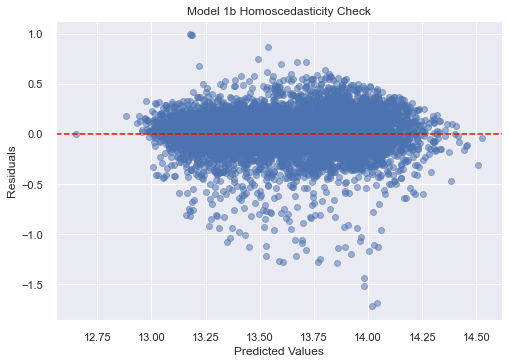

In [144]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 1b Homoscedasticity Check')
plt.grid(True)
plt.show()

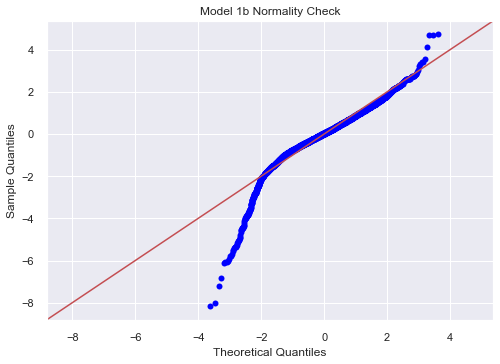

In [145]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 1b Normality Check")
plt.show()

In [146]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.21045350813759633
Model Predictions are off by a factor of 1.23 times the actual price.


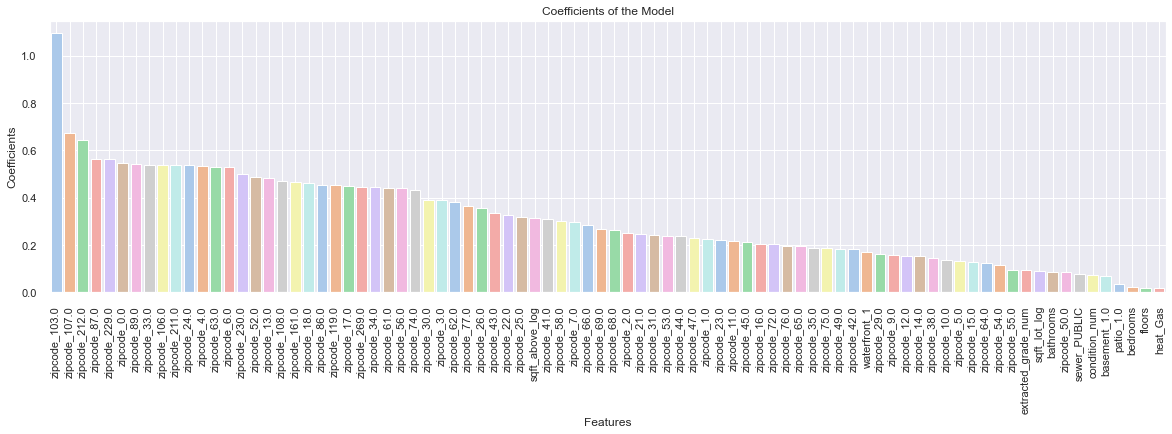

In [147]:
# Get the coefficients from the fitted model
coefficients = model.params

# Determine top 30 features 
top_features = coefficients.drop('const').abs().nlargest(100)

# Create a bar graph to visualize the coefficients
plt.figure(figsize=(20, 5))
sns.barplot(x=top_features.index, y=top_features.values, palette='pastel')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Coefficients of the Model')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.grid(True)  
plt.show()

**Observations:**
* We have a Homoscedasticity Fail. 
* We fail the normality check as we still have heavy outliers on one tail despite log transformation on all continuous features and removal of outlier beyond 1 std. 
* This model represents 68% of the variance found in price_log. 
* The Model Predictions are off by a factor of 1.23 times the actual price.
* The model is statistically significant. 

**Next Steps:**
* Create a model with only price_log and the other features non transformed. 

## Model 2 that includes only log_price transformation

In [148]:
# Make dataframe copy
m1c_df = clean.copy()

# Convert values back to original values
m1c_df['sqft_above'] = np.exp(m1c_df['sqft_above_log'])
m1c_df['sqft_lot'] = np.exp(m1c_df['sqft_lot_log'])
# Drop old values
m1c_df.drop(labels=['sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

In [149]:
# Specify the model parameters
X = m1c_df.drop(labels='price_log', axis=1)
y = m1c_df['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [150]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     638.9
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:41:55   Log-Likelihood:                -8748.0
No. Observations:               30110   AIC:                         1.771e+04
Df Residuals:                   30004   BIC:                         1.859e+04
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12

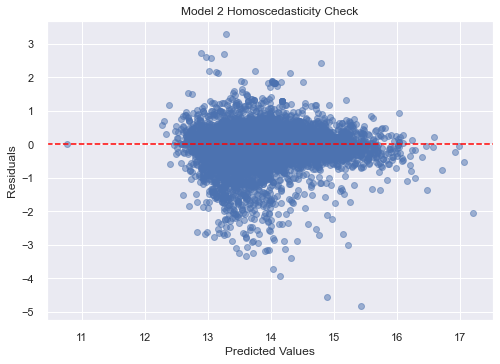

In [151]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 2 Homoscedasticity Check')
plt.grid(True)
plt.show()

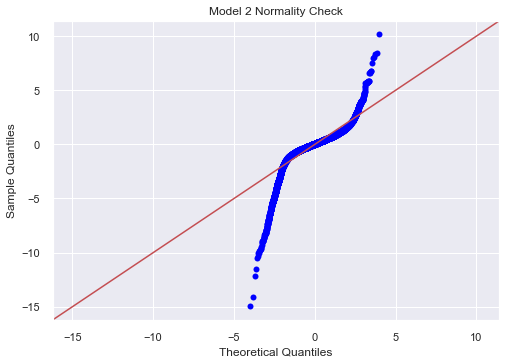

In [152]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 2 Normality Check")
plt.show()

In [153]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.3235489641256842
Model Predictions are off by a factor of 1.38 times the actual price.


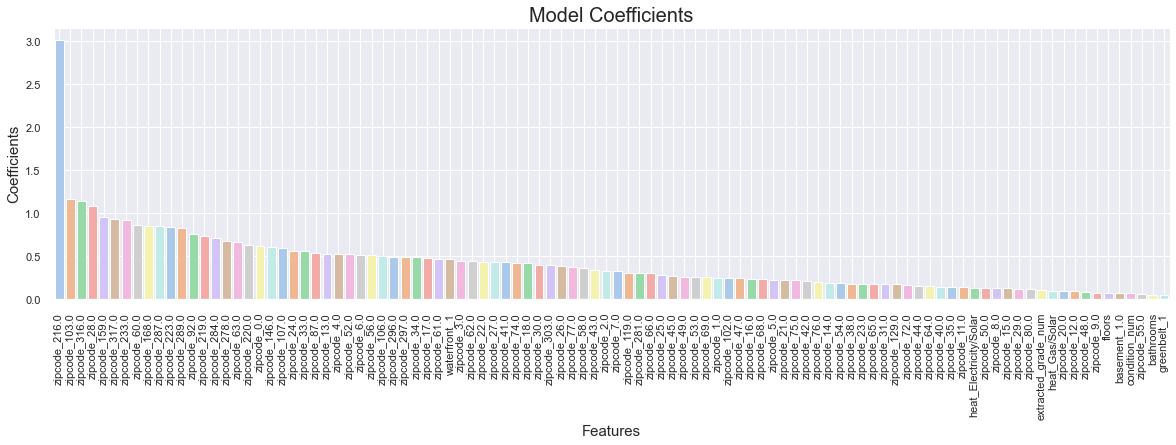

In [155]:
# Get the coefficients from the fitted model
coefficients = model.params

# Determine top 30 features 
top_features = coefficients.drop('const').abs().nlargest(100)

# Create a bar graph to visualize the coefficients
# Set custom font sizes for the plot
sns.set(font_scale=1.0)
plt.figure(figsize=(20, 5))
sns.barplot(x=top_features.index, y=top_features.values, palette='pastel')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Coefficients', fontsize=15)
plt.title('Model Coefficients', fontsize=20)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.grid(True)  
plt.show()

**Observations:**
* We do not pass Homoscedasticity
* The data is not normally distributed as the Q-Q plot shows heavy outliers. 
* Model is statistically significant
* Model Predictions are off by a factor of 1.38 times the actual price.
* Model Interpretability is better since the only log transformation is price. 
* Model represents 69% of the variance in price_log
**Next Steps:**
* Create a the same model with outliers removed 2 standard deviations away. 

## Model 2a outliers removed 2 std away

In [254]:
# Make dataframe copy
m2a_df = clean.copy()

# Convert values back to original values to remove outliers
m2a_df['price'] = np.exp(m2a_df['price_log'])
m2a_df['sqft_above'] = np.exp(m2a_df['sqft_above_log'])
m2a_df['sqft_lot'] = np.exp(m2a_df['sqft_lot_log'])
# Drop old values
m2a_df.drop(labels=['sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

In [255]:
# Create subset of columns
columns_of_interest = ['price', 'sqft_above', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition_num', 'extracted_grade_num']

# Use function to remove outliers 2 std away
# Create a dictionary so we can inspect how many outliers were removed per column
outliers_removed_count = {}

# Loop through the columns of interest and remove outliers
for col in columns_of_interest:
    model1b_out, num_outliers_removed = remove_outliers(m2a_df, col, 2)
    outliers_removed_count[col] = num_outliers_removed

print(outliers_removed_count)

m2a_df.head()

{'price': 945, 'sqft_above': 1331, 'sqft_lot': 443, 'bedrooms': 810, 'bathrooms': 469, 'floors': 1117, 'condition_num': 3190, 'extracted_grade_num': 730}


,price_log,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_above,sqft_lot
21177,12.422989,3,1.5,1.0,4,7,0,0,0,1,...,0,0,0,0,0,0,0,248448.0,1790.0,39808.0
10844,13.319574,4,1.5,1.5,4,7,0,0,0,1,...,0,0,0,0,0,0,0,609000.0,2232.0,12866.0
9292,13.835313,5,2.0,1.0,4,8,0,0,1,0,...,0,0,0,0,0,0,0,1020000.0,1380.0,15156.0
17878,13.321214,5,2.0,1.0,3,7,0,0,1,0,...,0,0,0,0,0,0,0,610000.0,1210.0,15552.0
11853,13.038982,3,1.0,1.5,4,6,0,0,1,0,...,0,0,0,0,0,0,0,460000.0,1010.0,7599.0


In [256]:
# convert price col back to price_log
m2a_df['price_log'] = np.log(m2a_df['price'])
# Drop price column
m2a_df.drop(labels='price', axis=1, inplace=True)

In [257]:
# Specify the model parameters
X = m2a_df.drop(labels='price_log', axis=1)
y = m2a_df['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [258]:
# Get the p-values from the model results
p_values = model.pvalues

# Extract the features with null p-values
features_with_null_p_values = p_values[p_values.isnull()].index.tolist()

# Manually drop features with null p-values from the DataFrame
X = X.drop(features_with_null_p_values, axis=1)

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [259]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     331.4
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:21:39   Log-Likelihood:                -4633.0
No. Observations:               21075   AIC:                             9466.
Df Residuals:                   20975   BIC:                         1.026e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.1432    

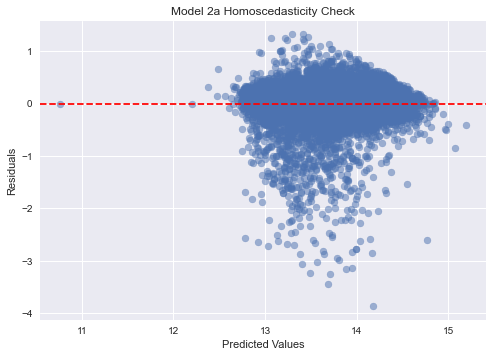

In [260]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 2a Homoscedasticity Check')
plt.grid(True)
plt.show()

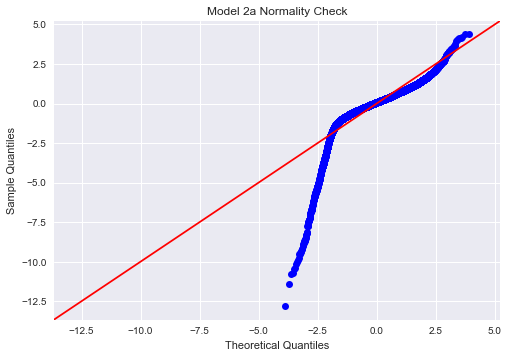

In [261]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 2a Normality Check")
plt.show()

In [262]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.30146469009917887
Model Predictions are off by a factor of 1.35 times the actual price.


**Observations:**
* Model is not Homoscedastic
* Model also does not pass normality check 
* Model represents about 60% of the variance in price_log
* Model Predictions are off by a factor of 1.35 times the actual price.
* Model is statistically significant

**Next Steps:** 
* Create a model with outliers removed 1 std away

## Model 2b outliers removed 1 std away

In [263]:
# Make dataframe copy
m2b_df = clean.copy()

# Convert values back to original values to remove outliers
m2b_df['price'] = np.exp(m2b_df['price_log'])
m2b_df['sqft_above'] = np.exp(m2b_df['sqft_above_log'])
m2b_df['sqft_lot'] = np.exp(m2b_df['sqft_lot_log'])
# Drop old values
m2b_df.drop(labels=['price_log', 'sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

In [264]:
# Create subset of columns
columns_of_interest = ['price', 'sqft_above', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition_num', 'extracted_grade_num']

# Use function to remove outliers 2 std away
# Create a dictionary so we can inspect how many outliers were removed per column
outliers_removed_count = {}

# Loop through the columns of interest and remove outliers
for col in columns_of_interest:
    m2b_df, num_outliers_removed = remove_outliers(m2b_df, col, 1)
    outliers_removed_count[col] = num_outliers_removed

print(outliers_removed_count)

m2b_df.head()

{'price': 3002, 'sqft_above': 7651, 'sqft_lot': 550, 'bedrooms': 3458, 'bathrooms': 5704, 'floors': 506, 'condition_num': 1239, 'extracted_grade_num': 833}


,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,patio_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_above,sqft_lot
16901,4,2.0,1.5,4,7,0,0,1,0,1,...,0,0,0,0,0,0,0,800000.0,2170.0,27275.0
7032,3,2.5,2.0,3,7,0,0,0,0,1,...,0,0,0,0,0,0,0,586000.0,1480.0,5335.0
17126,4,2.0,1.0,3,7,0,0,1,0,0,...,0,0,0,0,0,0,0,584000.0,1460.0,8490.0
11384,4,2.0,2.0,3,8,0,0,1,0,1,...,0,0,0,0,0,0,0,1000000.0,1880.0,7200.0
20654,4,2.0,2.0,4,8,0,0,1,1,1,...,0,0,0,0,0,0,0,1471000.0,1590.0,3655.0


In [265]:
# convert price col back to price_log
m2b_df['price_log'] = np.log(m2b_df['price'])
# Drop price column
m2b_df.drop(labels='price', axis=1, inplace=True)

In [266]:
# Specify the model parameters
X = m2b_df.drop(labels='price_log', axis=1)
y = m2b_df['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [267]:
# Get the p-values from the model results
p_values = model.pvalues

# Extract the features with null p-values
features_with_null_p_values = p_values[p_values.isnull()].index.tolist()

# Manually drop features with null p-values from the DataFrame
X = X.drop(features_with_null_p_values, axis=1)

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [268]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     180.8
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:21:42   Log-Likelihood:                 929.05
No. Observations:                7167   AIC:                            -1700.
Df Residuals:                    7088   BIC:                            -1157.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.0890    

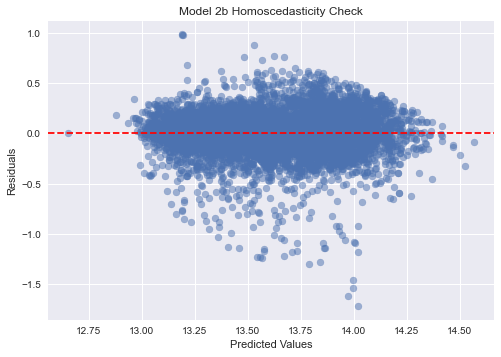

In [269]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 2b Homoscedasticity Check')
plt.grid(True)
plt.show()

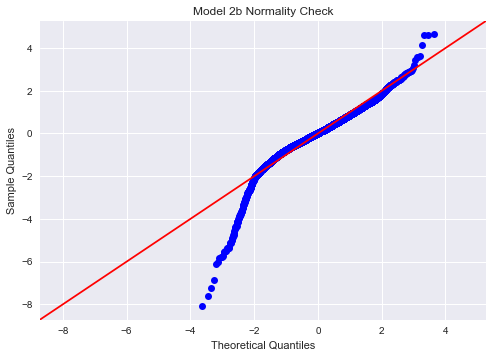

In [270]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 2b Normality Check")
plt.show()

In [271]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.21255222369534896
Model Predictions are off by a factor of 1.24 times the actual price.


**Observations:**
* Model is not Homoscedastic.
* Model does not display normal distribution.
* Model explains about 66% of the variance in price_log.
* Model Predictions are off by a factor of 1.24 times the actual price.

**Next Steps:**
* Create a simple model with only the top 4 features. 

## Model 3 with top 4 features

Model 1 has a lot of features so that being said lets see if we can still capture most of the variance and on top of that use less features.

In [272]:
# Identify top 3 features
clean.corr()["price_log"].sort_values(ascending=False)

price_log              1.000000
extracted_grade_num    0.614471
sqft_above_log         0.522001
bathrooms              0.516526
bedrooms               0.345930
                         ...   
zipcode_13.0          -0.115221
zipcode_3.0           -0.118008
zipcode_17.0          -0.118891
zipcode_24.0          -0.119903
zipcode_0.0           -0.135357
Name: price_log, Length: 352, dtype: float64

In [273]:
# Specify the model parameters
X = clean[['extracted_grade_num', 'sqft_above_log', 'bathrooms', 'bedrooms']]
y = clean['price_log']

# Make Model 3
model3 = sm.OLS(y, sm.add_constant(X))
model3_results = model3.fit()
print(model3_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     5226.
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:21:47   Log-Likelihood:                -18487.
No. Observations:               30110   AIC:                         3.698e+04
Df Residuals:                   30105   BIC:                         3.703e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.7053    

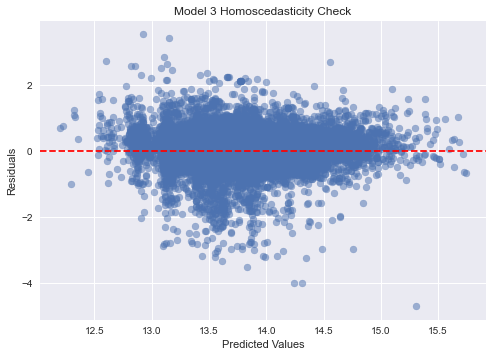

In [274]:
# View model predictions
predicted_values = model3_results.fittedvalues
residuals = model3_results.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 3 Homoscedasticity Check')
plt.grid(True)
plt.show()

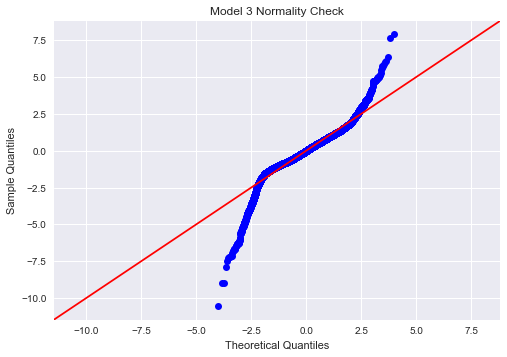

In [275]:
sm.graphics.qqplot(model3_results.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 3 Normality Check")
plt.show()

In [276]:
# Get the predictions from the fitted model
predictions = model3_results.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.4471105062962519
Model Predictions are off by a factor of 1.56 times the actual price.


**Observations:** 
* The model overall is statistically significant with a F-statistic p-value less than 0.05.
* All features are statistically significant.
* The model describes about 40% of the variance in price_log. 
* It seems that excluding the zipcode/location of a home significantly impacted the prediction of price_log.
* Model predictions are off by a factor of 1.56 timees the actual price. 
* The residuals however show Heteroscedascity which is not good. It should be have a behavior closer to Homoscedascity where the data is randmonly scattered.

## Model 3a Top 4 Features with outliers 2 std devation away removed

In [277]:
# Make dataframe copy
m3a_df = clean.copy()

# Convert values back to original values to remove outliers
m3a_df['price'] = np.exp(m3a_df['price_log'])
m3a_df['sqft_above'] = np.exp(m3a_df['sqft_above_log'])
m3a_df['sqft_lot'] = np.exp(m3a_df['sqft_lot_log'])
# Drop old values
m3a_df.drop(labels=['sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

In [278]:
# Create subset of columns
columns_of_interest = ['price', 'sqft_above', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition_num', 'extracted_grade_num']

# Use function to remove outliers 2 std away
# Create a dictionary so we can inspect how many outliers were removed per column
outliers_removed_count = {}

# Loop through the columns of interest and remove outliers
for col in columns_of_interest:
    m3a_df, num_outliers_removed = remove_outliers(m3a_df, col, 2)
    outliers_removed_count[col] = num_outliers_removed

print(outliers_removed_count)

m3a_df.head()

{'price': 945, 'sqft_above': 1331, 'sqft_lot': 443, 'bedrooms': 810, 'bathrooms': 469, 'floors': 1117, 'condition_num': 3190, 'extracted_grade_num': 730}


,price_log,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_above,sqft_lot
21177,12.422989,3,1.5,1.0,4,7,0,0,0,1,...,0,0,0,0,0,0,0,248448.0,1790.0,39808.0
10844,13.319574,4,1.5,1.5,4,7,0,0,0,1,...,0,0,0,0,0,0,0,609000.0,2232.0,12866.0
9292,13.835313,5,2.0,1.0,4,8,0,0,1,0,...,0,0,0,0,0,0,0,1020000.0,1380.0,15156.0
17878,13.321214,5,2.0,1.0,3,7,0,0,1,0,...,0,0,0,0,0,0,0,610000.0,1210.0,15552.0
11853,13.038982,3,1.0,1.5,4,6,0,0,1,0,...,0,0,0,0,0,0,0,460000.0,1010.0,7599.0


In [279]:
# convert col back to log
m3a_df['price_log'] = np.log(m3a_df['price'])
m3a_df['sqft_above_log'] = np.log(m3a_df['sqft_above'])
# Drop columns
m3a_df.drop(labels=['price', 'sqft_above'], axis=1, inplace=True)

In [280]:
# Specify the model parameters
X = m3a_df[['extracted_grade_num', 'sqft_above_log', 'bathrooms', 'bedrooms']]
y = m3a_df['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [281]:
# Get the p-values from the model results
p_values = model.pvalues

# Extract the features with null p-values
features_with_null_p_values = p_values[p_values.isnull()].index.tolist()

# Manually drop features with null p-values from the DataFrame
X = X.drop(features_with_null_p_values, axis=1)

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [282]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     1737.
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:21:47   Log-Likelihood:                -11552.
No. Observations:               21075   AIC:                         2.311e+04
Df Residuals:                   21070   BIC:                         2.315e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.9470    

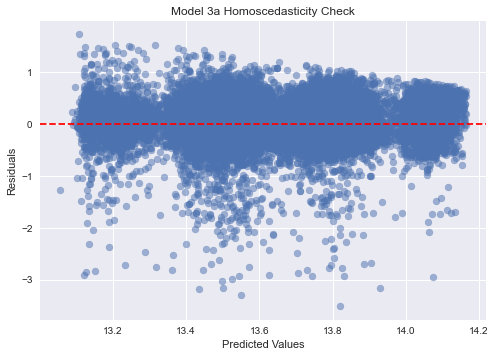

In [283]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 3a Homoscedasticity Check')
plt.grid(True)
plt.show()

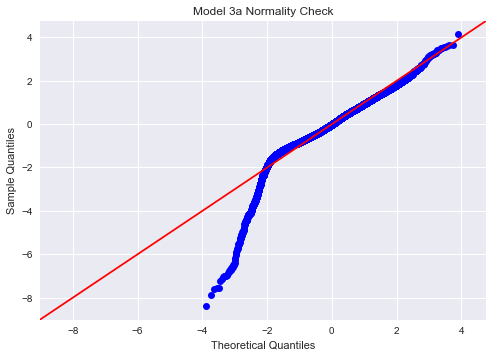

In [284]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 3a Normality Check")
plt.show()

In [285]:
# Get the predictions from the fitted model
predictions = model.predict(sm.add_constant(X))

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by a factor of {round(np.exp(rmse),2)} times the actual price.")

Root Mean Square Error (RMSE): 0.41862258620994197
Model Predictions are off by a factor of 1.52 times the actual price.


**Observations:**
* The model overall is statistically significant
* The model explains about 30% of the variance in price_log
* Model does not pass normality test
* Model does not pass Homoscedasticity test however its very close to passing. 


## Polynomial Regression Modeling (Model 4)

We keep failing normality and homoscedascity assumptions. The troublesome features that express this are price, and any sqft feature. Lets atempt a x^2 regression. 

In [286]:
# Create new dataframe for polynomial
poly_2 = clean.copy()

We need to transform the 'price_log', 'sqft_lot_log', 'sqft_above_log' back to original values

In [287]:
# Transform features
poly_2['price'] = np.exp(poly_2['price_log'])
poly_2['sqft_lot'] = np.exp(poly_2['sqft_lot_log'])
poly_2['sqft_above'] = np.exp(poly_2['sqft_above_log'])
# Drop old features
poly_2.drop(labels=['price_log', 'sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

In [288]:
# Check for NaN values in the entire DataFrame
nan_check = poly_2.isna()

# Check for NaN values in specific columns
nan_check_columns = poly_2.columns.isna()

# Check if there are any NaN values in the entire DataFrame
if nan_check.any().any():
    print("There are NaN values in the following columns:")
    columns_with_nan = nan_check.any()[nan_check.any()].index
    print(columns_with_nan)
else:
    print("There are no NaN values in the DataFrame.")

There are no NaN values in the DataFrame.


In [289]:
poly_2.head()

,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,patio_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_lot,sqft_above
21177,3,1.5,1.0,4,7,0,0,0,1,1,...,0,0,0,0,0,0,0,248448.0,39808.0,1790.0
10844,4,1.5,1.5,4,7,0,0,0,1,1,...,0,0,0,0,0,0,0,609000.0,12866.0,2232.0
9292,5,2.0,1.0,4,8,0,0,1,0,0,...,0,0,0,0,0,0,0,1020000.0,15156.0,1380.0
17878,5,2.0,1.0,3,7,0,0,1,0,1,...,0,0,0,0,0,0,0,610000.0,15552.0,1210.0
14450,3,2.0,1.5,5,7,0,0,0,0,0,...,0,0,0,0,0,0,0,700000.0,8620.0,1720.0


In [290]:
# Only want to transform the continuous data to x^2
poly_2['sqft_above^2'] = poly_2['sqft_above']**2
poly_2['sqft_lot^2'] = poly_2['sqft_lot']**2

# Drop old values 
poly_2.drop(labels=['sqft_above', 'sqft_lot'], axis=1, inplace=True)

In [291]:
poly_2.head()

,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,patio_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_above^2,sqft_lot^2
21177,3,1.5,1.0,4,7,0,0,0,1,1,...,0,0,0,0,0,0,0,248448.0,3204100.0,1.584677e+09
10844,4,1.5,1.5,4,7,0,0,0,1,1,...,0,0,0,0,0,0,0,609000.0,4981824.0,1.655340e+08
9292,5,2.0,1.0,4,8,0,0,1,0,0,...,0,0,0,0,0,0,0,1020000.0,1904400.0,2.297043e+08
17878,5,2.0,1.0,3,7,0,0,1,0,1,...,0,0,0,0,0,0,0,610000.0,1464100.0,2.418647e+08
14450,3,2.0,1.5,5,7,0,0,0,0,0,...,0,0,0,0,0,0,0,700000.0,2958400.0,7.430440e+07


In [292]:
X = poly_2.drop(labels=['price'], axis=1)
y = poly_2['price']

poly_2_results = sm.OLS(y, X).fit()

In [293]:
print(poly_2_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     264.3
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:21:49   Log-Likelihood:            -4.4000e+05
No. Observations:               30110   AIC:                         8.804e+05
Df Residuals:                   29907   BIC:                         8.821e+05
Df Model:                         202                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
bedrooms               -2.02

In [294]:
import pandas as pd
import statsmodels.api as sm

# Specify the model parameters
X = poly_2.drop(labels=['price'], axis=1)
y = poly_2['price']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [295]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     607.6
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:21:51   Log-Likelihood:            -4.4002e+05
No. Observations:               30110   AIC:                         8.802e+05
Df Residuals:                   30021   BIC:                         8.810e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6.391e+05   3

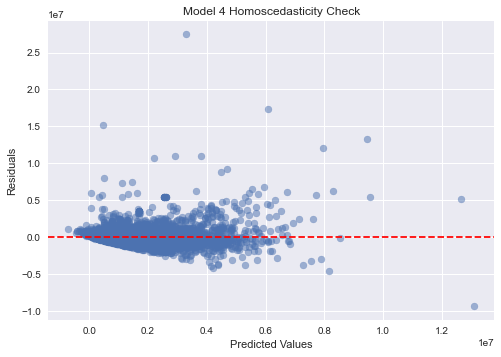

In [296]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 4 Homoscedasticity Check')
plt.grid(True)
plt.show()

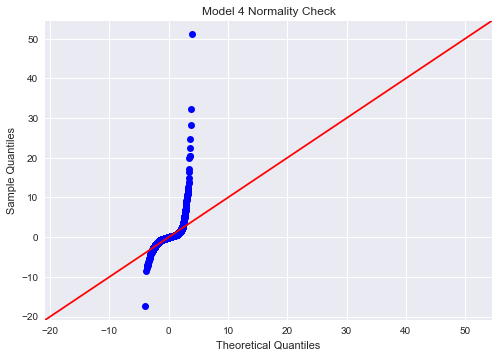

In [297]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 4 Normality Check")
plt.show()

In [298]:
# Get the predictions from the fitted model
predictions = model.predict(X)

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by {round((rmse),2)} dollars off the actual price.")

Root Mean Square Error (RMSE): 537578.2645135914
Model Predictions are off by 537578.26 dollars off the actual price.


**Observations:**
* The interpretability of the results is much easier than log transforming every feature. 
* The variance is at about 65% which is almost as good as the first model without sacrficing model interpretability. 
* Model predictabilityis off by a lot and fails normality and homoscedacity. 
* Overall the model is statistically significant. 

## Model 4a with outliers removed 2 std away

In [299]:
# Create new dataframe for polynomial
poly_2_out = clean.copy()

In [300]:
# Transform features back to normal to attempt poly regression
poly_2_out['price'] = np.exp(poly_2_out['price_log'])
poly_2_out['sqft_lot'] = np.exp(poly_2_out['sqft_lot_log'])
poly_2_out['sqft_above'] = np.exp(poly_2_out['sqft_above_log'])
# Drop old features
poly_2_out.drop(labels=['price_log', 'sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

In [301]:
# Create subset of columns
columns_of_interest = ['price', 'sqft_above', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition_num', 'extracted_grade_num']

# Use function to remove outliers 2 std away
# Create a dictionary so we can inspect how many outliers were removed per column
outliers_removed_count = {}

# Loop through the columns of interest and remove outliers
for col in columns_of_interest:
    poly_2_out, num_outliers_removed = remove_outliers(poly_2_out, col, 2)
    outliers_removed_count[col] = num_outliers_removed

print(outliers_removed_count)

poly_2_out.head()

{'price': 945, 'sqft_above': 1331, 'sqft_lot': 443, 'bedrooms': 810, 'bathrooms': 469, 'floors': 1117, 'condition_num': 3190, 'extracted_grade_num': 730}


,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,patio_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_lot,sqft_above
21177,3,1.5,1.0,4,7,0,0,0,1,1,...,0,0,0,0,0,0,0,248448.0,39808.0,1790.0
10844,4,1.5,1.5,4,7,0,0,0,1,1,...,0,0,0,0,0,0,0,609000.0,12866.0,2232.0
9292,5,2.0,1.0,4,8,0,0,1,0,0,...,0,0,0,0,0,0,0,1020000.0,15156.0,1380.0
17878,5,2.0,1.0,3,7,0,0,1,0,1,...,0,0,0,0,0,0,0,610000.0,15552.0,1210.0
11853,3,1.0,1.5,4,6,0,0,1,0,1,...,0,0,0,0,0,0,0,460000.0,7599.0,1010.0


In [302]:
# Only want to transform the continuous data to x^2
poly_2_out['sqft_above^2'] = poly_2_out['sqft_above']**2
poly_2_out['sqft_lot^2'] = poly_2_out['sqft_lot']**2

# Drop old values 
poly_2_out.drop(labels=['sqft_above', 'sqft_lot'], axis=1, inplace=True)

Create polynomial model

In [303]:
# Specify the model parameters
X = poly_2_out.drop(labels=['price'], axis=1)
y = poly_2_out['price']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [304]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     397.2
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:21:53   Log-Likelihood:            -2.9211e+05
No. Observations:               21075   AIC:                         5.844e+05
Df Residuals:                   20966   BIC:                         5.853e+05
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -3.117e+05   2

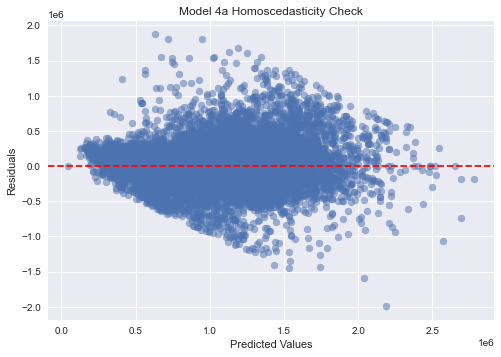

In [305]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 4a Homoscedasticity Check')
plt.grid(True)
plt.show()

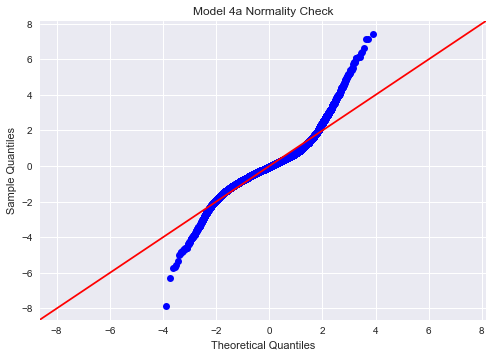

In [306]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 4a Normality Check")
plt.show()

In [145]:
# Get the predictions from the fitted model
predictions = model.predict(X)

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by {round((rmse),2)} dollars off the actual price.")

Root Mean Square Error (RMSE): 253072.0173309085
Model Predictions are off by 253072.02 dollars off the actual price.


**Observations:**
* Model does not pass Homoscedasticity Test.
* Model does not pass Normality Test.
* Model explains about 67% of the variance in price.
* Model is statistically significant.
* Model Predictions are off by 253072.02 dollars off the actual price.

## Model 4b with outliers removed 1 std away

In [146]:
# Create new dataframe for polynomial
poly_2_out_1 = clean.copy()

In [147]:
# Transform features back to normal to attempt poly regression
poly_2_out_1['price'] = np.exp(poly_2_out_1['price_log'])
poly_2_out_1['sqft_lot'] = np.exp(poly_2_out_1['sqft_lot_log'])
poly_2_out_1['sqft_above'] = np.exp(poly_2_out_1['sqft_above_log'])
# Drop old features
poly_2_out_1.drop(labels=['price_log', 'sqft_above_log', 'sqft_lot_log'], axis=1, inplace=True)

Remove Outliers greater than 1 std deviation away from mean

In [148]:
# Create subset of columns
columns_of_interest = ['price', 'sqft_above', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'condition_num', 'extracted_grade_num']

# Use function to remove outliers 2 std away
# Create a dictionary so we can inspect how many outliers were removed per column
outliers_removed_count = {}

# Loop through the columns of interest and remove outliers
for col in columns_of_interest:
    poly_2_out_1, num_outliers_removed = remove_outliers(poly_2_out_1, col, 1)
    outliers_removed_count[col] = num_outliers_removed

print(outliers_removed_count)

poly_2_out_1.head()

{'price': 3002, 'sqft_above': 7651, 'sqft_lot': 550, 'bedrooms': 3458, 'bathrooms': 5704, 'floors': 506, 'condition_num': 1239, 'extracted_grade_num': 833}


,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,basement_1.0,garage_1.0,patio_1.0,...,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0,price,sqft_lot,sqft_above
16901,4,2.0,1.5,4,7,0,0,1,0,1,...,0,0,0,0,0,0,0,800000.0,27275.0,2170.0
7032,3,2.5,2.0,3,7,0,0,0,0,1,...,0,0,0,0,0,0,0,586000.0,5335.0,1480.0
17126,4,2.0,1.0,3,7,0,0,1,0,0,...,0,0,0,0,0,0,0,584000.0,8490.0,1460.0
11384,4,2.0,2.0,3,8,0,0,1,0,1,...,0,0,0,0,0,0,0,1000000.0,7200.0,1880.0
20654,4,2.0,2.0,4,8,0,0,1,1,1,...,0,0,0,0,0,0,0,1471000.0,3655.0,1590.0


Transform data to ^2

In [149]:
# Only want to transform the continuous data to x^2
poly_2_out_1['sqft_above^2'] = poly_2_out_1['sqft_above']**2
poly_2_out_1['sqft_lot^2'] = poly_2_out_1['sqft_lot']**2

# Drop old values 
poly_2_out_1.drop(labels=['sqft_above', 'sqft_lot'], axis=1, inplace=True)

Make polynomial model

In [150]:
# Specify the model parameters
X = poly_2_out_1.drop(labels=['price'], axis=1)
y = poly_2_out_1['price']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [151]:
# Get the p-values from the model results
p_values = model.pvalues

# Extract the features with null p-values
features_with_null_p_values = p_values[p_values.isnull()].index.tolist()

# Manually drop features with null p-values from the DataFrame
X = X.drop(features_with_null_p_values, axis=1)

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [152]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     181.4
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:58:47   Log-Likelihood:                -97392.
No. Observations:                7167   AIC:                         1.949e+05
Df Residuals:                    7091   BIC:                         1.955e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.689e+05   4

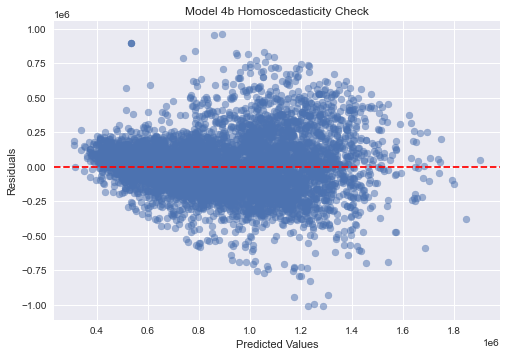

In [153]:
# View model predictions
predicted_values = model.fittedvalues
residuals = model.resid

# Generate the residual plot
fig, ax = plt.subplots()
ax.scatter(predicted_values, residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Model 4b Homoscedasticity Check')
plt.grid(True)
plt.show()

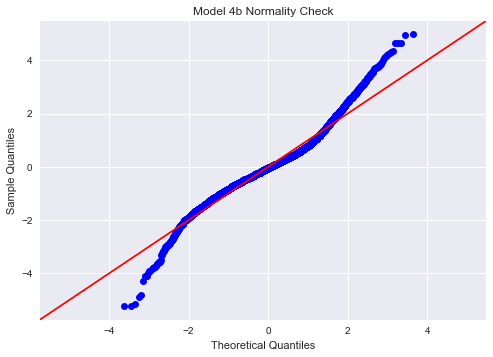

In [154]:
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title("Model 4b Normality Check")
plt.show()

In [155]:
# Get the predictions from the fitted model
predictions = model.predict(X)

# Step 3: Calculate the squared differences between predicted and actual values
squared_errors = (y - predictions) ** 2

# Step 4: Calculate the mean of the squared differences
mean_squared_error = np.mean(squared_errors)

# Step 5: Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Square Error (RMSE):", rmse)
print(f"Model Predictions are off by {round((rmse),2)} dollars off the actual price.")

Root Mean Square Error (RMSE): 192922.65451183027
Model Predictions are off by 192922.65 dollars off the actual price.


**Observations:**
* Model does not pass Homoscedasticity test.
* Model does not pass Normality test.
* Model is statistically significant.
* Model Predictions are off by 192922.65 dollars off the actual price.
* This model is easily interpretable.

## Model Sumamry
| Model   | Description                                                                              | Num of Features | r^2 | Accuracy | Root Mean Square Err (RMSE)  | RMSE Interpretation                                                                      | Normality | Homoscedasticity | 
|:--------|:-----------------------------------------------------------------------------------------|:----------------|:----|:---------|:-----------------------------|:-----------------------------------------------------------------------------------------|:----------|------------------|
| Model 1 | All features with continuous variables log transformed                                   |       351       |0.697| 69.70%   |0.32018251682706217           |Model Predictions are off by a factor of 1.38 times the actual price.                     |Fail       |Fail              |
| Model 1a| All features and outliers 2 standard deviations away removed                             |       102       |0.611| 61.10%   |0.30038837634144505           |Model Predictions are off by a factor of 1.35 times the actual price.                     |Fail       |Fail              |
| Model 1b| All features and outliers 1 standard deviation away removed                              |       84        |0.668| 66.80%   |0.21045350813759633           |Model Predictions are off by a factor of 1.23 times the actual price.                     |Fail       |Fail              |
| Model 2 | All features but only includes log transformaion of price                                |       105       |0.690| 69.00%   |0.3235489641256842            |Model Predictions are off by a factor of 1.38 times the actual price.                     |Fail       |Fail              |
| Model 2a| Same as Model 2 and outliers 2 standard deviations away removed                          |       99        |0.680| 68.00%   |0.30146469009917887           |Model Predictions are off by a factor of 1.35 times the actual price.                     |Fail       |Fail              |
| Model 2b| Same as Model 2 and outliers 1 standard deviations away removed                          |       78        |0.662| 66.20%   |0.21255222369534896           |Model Predictions are off by a factor of 1.24 times the actual price.                     |Fail       |Fail              |
| Model 3 | Top 4 features correlated with price_log                                                 |       4         |0.410| 41.00%   |0.4471105062962519            |Model Predictions are off by a factor of 1.56 times the actual price.                     |Fail       |Fail              |
| Model 3a| Same as Model 3 and outliers 2 standards deviations away removed                         |       4         |0.248| 24.80%   |0.41862258620994197           |Model Predictions are off by a factor of 1.52 times the actual price.                     |Fail       |Fail              |
| Model 4 | All continuous variables not log transformed and polynomial transformation (x^2)         |       88        |0.639| 63.90%   |537578.2645135914             |Model Predictions are off by 537578.26 dollars off the actual price.                      |Fail       |Fail              |
| Model 4a| Same as Model 4 and outliers 2 standard deviations away removed                          |       108       |0.670| 67.00%   |253072.0173309085             |Model Predictions are off by 253072.02 dollars off the actual price.                      |Fail       |Fail              |
| Model 4b| Same as Model 4 and outliers 1 standard deviation away removed                           |       75        |0.654| 65.40%   |192922.65451183027            |Model Predictions are off by 192922.65 dollars off the actual price.                      |Fail       |Fail              |
